In [31]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn


import seaborn as sns
# Set up some parameters for pretty plots
import matplotlib as mpl
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Colors & styles adjustments for better visibility on both backgrounds
text_and_line_color = '#808080'
plt.rcParams['text.color'] = text_and_line_color
plt.rcParams['axes.labelcolor'] = text_and_line_color
plt.rcParams['xtick.color'] = text_and_line_color
plt.rcParams['ytick.color'] = text_and_line_color
plt.rcParams['axes.edgecolor'] = text_and_line_color



In [32]:
### L1 SGD


class SGD_L1(torch.optim.SGD):
    def __init__(self, params, l1_lambda=0.01,weight_decay=0, *args, **kwargs):
        super(SGD_L1, self).__init__(params,weight_decay=0, *args, **kwargs)
        self.l1_lambda = l1_lambda
        self.WD=weight_decay

    @torch.no_grad()
    def step(self, closure=None):
        # standard SGD step
        loss = super(SGD_L1, self).step(closure)  

        # Soft thresholding
        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                p.data = torch.sign(p.data) * torch.clamp(torch.abs(p.data) - self.l1_lambda * lr, min=0)
                p.data /=(1+lr*self.WD)
                # p.data /=1+self.l1_lambda * lr/torch.abs(p.data)

        return loss

## First example, linear sparse teacher

In [33]:
#### Functions see blog post for details, same as Generalization I

# Define the training loss function
def training_loss_fn(S, T, Sigma):
    difference = S - T
    loss = difference @ Sigma @ difference/2
    return loss

# Define the validation loss function same as above, with Sigma->1
def validation_loss_fn(S, T):
    difference = S - T
    return torch.dot(difference, difference)/2




def get_extreme_eigenvalues(matrix):
    """Returns the smallest and largest non-vanishing eigenvalues of the matrix."""
    eigenvalues, _ = torch.linalg.eigh(matrix)
    sorted_eigenvalues = torch.sort(eigenvalues)[0]
    
    non_vanishing_eigenvalues = sorted_eigenvalues[sorted_eigenvalues > 1e-5]
    
    if len(non_vanishing_eigenvalues) == 0:
        raise ValueError("All eigenvalues are vanishing!")
    
    min_eigenvalue = non_vanishing_eigenvalues[0]
    max_eigenvalue = non_vanishing_eigenvalues[-1]
    
    return min_eigenvalue, max_eigenvalue

def compute_optimal_hyperparameters(matrix):
    """
    Compute all optimal hyperparameters. 
    Following the wonderful Distil article "Why Momentum Really Works"
    (https://distill.pub/2017/momentum/)
    The only differnces are that when an L_2 norm is included: 
    1. The minimal eigenvalue is WD
    2. The maximal eigenvalue is WD+lamnda_max
    3. WD is chose such that the convergence rate is the same inn both cases
    """
    
    # eigenvalues
    min_eigenvalue, max_eigenvalue=get_extreme_eigenvalues(matrix)

    # Optimal weight decay
    WD = max_eigenvalue * min_eigenvalue / (max_eigenvalue - min_eigenvalue)
    
    # Learning rates without momentum
    LR_0 = 2 / (max_eigenvalue + min_eigenvalue)
    LR_WD = 2 / (max_eigenvalue + 2 * WD)
    
    # Learning rates with momentum
    LR_beta = (2 / (torch.sqrt(max_eigenvalue) + torch.sqrt(min_eigenvalue)))**2
    LR_beta_WD = (2 / (torch.sqrt(max_eigenvalue + WD) + torch.sqrt(WD)))**2
    
    # Optimal momentum values
    beta_0 = ((torch.sqrt(max_eigenvalue) - torch.sqrt(min_eigenvalue)) / 
              (torch.sqrt(max_eigenvalue) + torch.sqrt(min_eigenvalue)))**2
    beta_lam = ((torch.sqrt(max_eigenvalue + WD) - torch.sqrt(WD)) / 
                (torch.sqrt(max_eigenvalue + WD) + torch.sqrt(WD)))**2
    
    return {
        "WD": WD,
        "LR_0": LR_0,
        "LR_WD": LR_WD,
        "LR_beta": LR_beta,
        "LR_beta_WD": LR_beta_WD,
        "beta_0": beta_0,
        "beta_lam": beta_lam
    }

In [34]:
#### Training loop

def train_model(num_runs=100, epochs=500, sparse_teacher=False, lr_L1=0.4,l1_lambda=0.0005):
    # Setting up random seeds for reproducibility
    torch.manual_seed(98736)

    # inits
    n = 1000        # Dimension
    q = 7/10        # Fraction of training data (N_tr=q*n)

    if sparse_teacher:
        q_sparse = 6/10    # Sparsity fraction of T
        n_zeros = int(q_sparse*n)
        t = torch.randn(n-n_zeros)
        t = t / torch.norm(t)
        T = torch.cat((t, torch.zeros(n_zeros)), 0)
    else:
        T = torch.randn(n)
        T = T / torch.norm(T)

    # Initialize student vector
    Si = torch.nn.Parameter(torch.randn(n)/np.sqrt(q*n))

    # Lists to store all loss histories for each run
    loss_histories = {
        "no_WD": [],
        "WD": [],
        "SGD_L1": []
    }

    for run in tqdm.trange(num_runs):
        # Generate new data
        X = torch.randn(int(q*n), n)
        Sigma = X.T @ X / (q*n)
    
        # Compute optimal hyperparameters
        hyperparameters = compute_optimal_hyperparameters(Sigma)
    
        # Reset initial student vectors
        S_no_WD = Si.clone().detach().requires_grad_(True)
        S_WD = Si.clone().detach().requires_grad_(True)
        S_SGD_L1 = Si.clone().detach().requires_grad_(True)
    
        # Initialize optimizers with computed hyperparameters
        optimizer_no_WD = torch.optim.SGD([S_no_WD], lr=hyperparameters["LR_0"])
        optimizer_WD = torch.optim.SGD([S_WD], lr=hyperparameters["LR_WD"], weight_decay=hyperparameters["WD"])
        optimizer_SGD_L1 = SGD_L1([S_SGD_L1], l1_lambda=l1_lambda, lr=lr_L1)
    
        # Track loss history for each method
        loss_histories_for_run = {
            "no_WD": [validation_loss_fn(S_no_WD, T).item()],
            "WD": [validation_loss_fn(S_WD, T).item()],
            "SGD_L1": [validation_loss_fn(S_SGD_L1, T).item()]
        }
    
        for epoch in range(epochs):
            for method, optimizer in zip(loss_histories.keys(), [optimizer_no_WD, optimizer_WD, optimizer_SGD_L1]):
                optimizer.zero_grad()
                S = {
                    "no_WD": S_no_WD, 
                    "WD": S_WD, 
                    "SGD_L1": S_SGD_L1
                }[method]
            
                # Forward pass
                loss = training_loss_fn(S, T, Sigma)
            
                # Backward pass
                loss.backward()
            
                # Optimizer step
                optimizer.step()
            
                # Append history
                loss_histories_for_run[method].append(validation_loss_fn(S, T).item())
                
        # Append loss histories for this run
        for method in loss_histories.keys():
            loss_histories[method].append(loss_histories_for_run[method])
    
    return loss_histories, S_SGD_L1, T,Si


In [35]:
loss_histories_random,_,_,_=train_model(num_runs=10, epochs=500, sparse_teacher=False, lr_L1=0.4,l1_lambda=0.0012)
loss_histories_sparse, S_f, T, Si=train_model(num_runs=10, epochs=500, sparse_teacher=True, lr_L1=0.4,l1_lambda=0.0012)

100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


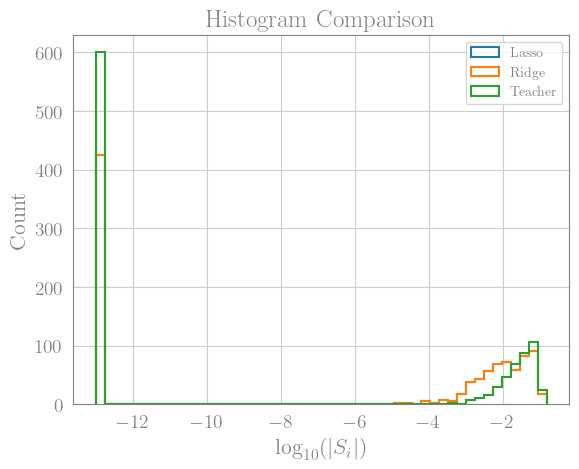

In [36]:
# Define  data
data1 = torch.log10(torch.abs(S_f)+1e-13).detach().numpy()
# data2 = torch.log10(torch.abs(S_WD)+1e-13).detach().numpy()
data3 = torch.log10(torch.abs(T)+1e-13).detach().numpy()

# Create the histogram for the first dataset and collect the bin edges
n, bins, patches = plt.hist(data1, 50, histtype='step', linewidth=1.5, label='Lasso')

# Use use the same bins for the second histogram
plt.hist(data1, bins=bins, histtype='step', linewidth=1.5, label='Ridge')
plt.hist(data3, bins=bins, histtype='step', linewidth=1.5, label='Teacher')


plt.legend(loc='upper right')
plt.xlabel(r'$\log_{10}(|S_i|)$')
plt.ylabel('Count')
plt.title('Histogram Comparison')

plt.show()


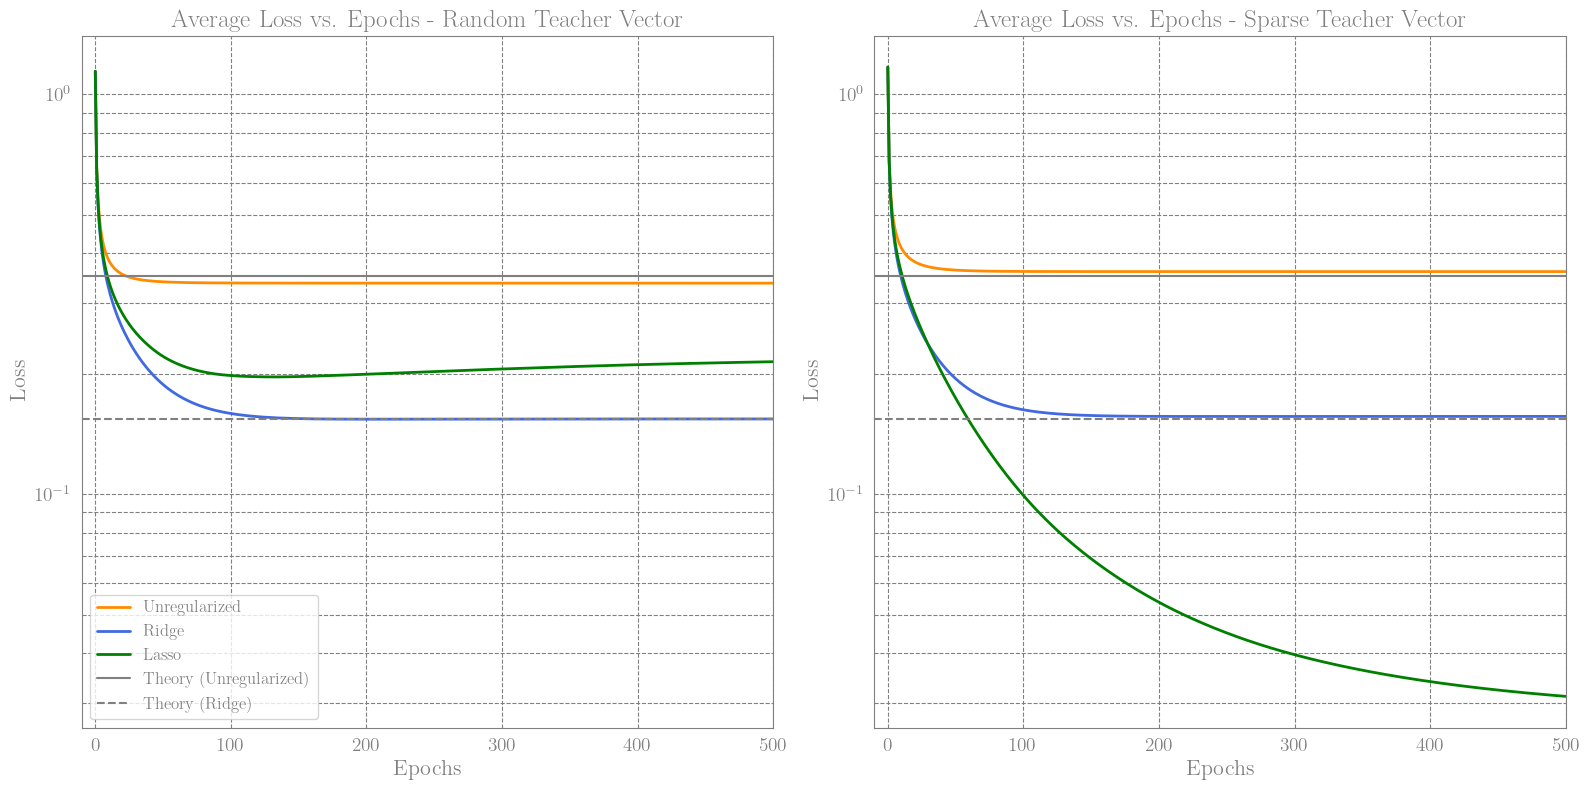

In [37]:
# Average over data realizations
avg_loss_histories_sparse = {method: np.mean(loss_histories_sparse[method], axis=0) for method in loss_histories_sparse}
avg_loss_histories_random = {method: np.mean(loss_histories_random[method], axis=0) for method in loss_histories_random}

q = 7/10        # Fraction of training data (N_tr=q*n)

colors = {
    "no_WD": "darkorange",
    "WD": "royalblue",
    "SGD_L1": "green"
}

linestyles = {
    "no_WD": "-",
    "WD": "-",
    "SGD_L1": "-"
}

labels = {
    "no_WD": r"Unregularized",
    "WD": r"Ridge",
    "SGD_L1": r"Lasso"
}

text_and_line_color = "gray"
order = ["no_WD", "WD", "SGD_L1"]

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot for Random Teacher
for method in order:
    axs[0].semilogy(avg_loss_histories_random[method], label=labels[method], color=colors[method], linestyle=linestyles[method], linewidth=2)

axs[0].axhline((1-q) * ((Si - T) @ (Si - T)).item()/2, color=text_and_line_color, ls='-', label=r"Theory (Unregularized)")
axs[0].axhline((1-q)*1.03/2, color=text_and_line_color, ls='--', label=r"Theory (Ridge)")
axs[0].set_title(r'Average Loss vs. Epochs - Random Teacher Vector')
axs[0].set_xlabel(r'Epochs')
axs[0].set_ylabel(r'Loss')
axs[0].set_xlim(-10, 500)
axs[0].legend(fontsize=12, loc='lower left')
axs[0].grid(True, which="both", ls="--", c=text_and_line_color)

# Plot for Sparse Teacher
for method in order:
    axs[1].semilogy(avg_loss_histories_sparse[method], label=labels[method], color=colors[method], linestyle=linestyles[method], linewidth=2)

axs[1].axhline((1-q) * ((Si - T) @ (Si - T)).item()/2, color=text_and_line_color, ls='-', label=r"Theory (No WD)")
axs[1].axhline((1-q)*1.03/2, color=text_and_line_color, ls='--', label=r"Theory (With WD)")
axs[1].set_title(r'Average Loss vs. Epochs - Sparse Teacher Vector')
axs[1].set_xlabel(r'Epochs')
axs[1].set_ylabel(r'Loss')
axs[1].set_xlim(-10, 500)

axs[1].grid(True, which="both", ls="--", c=text_and_line_color)



# Set the y-limits for both axes
axs[0].set_ylim(*axs[1].get_ylim())


plt.tight_layout()

# plt.savefig('/Users/nadavoutmezguine/Library/CloudStorage/Dropbox/Mac/Documents/Nadav-out.github.io/assets/images/gen_linear_sparse.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()


## Two layers

In [25]:
class StudentModel(nn.Module):
    def __init__(self, D, v):
        super(StudentModel, self).__init__()

        # Xavier/Glorot Initialization
        self.M = nn.Parameter(torch.randn(D, v) * np.sqrt(1. / D))
        self.V = nn.Parameter(torch.randn(v) * np.sqrt(1. / v))

    def forward(self, X):
        return  (self.M @ self.V)


In [26]:
import copy
def train_model(num_runs=100, epochs=500, lr_L1=0.4, l1_lambda=0.0005, lr_L2=0.04, WD=0.005):
    # random seed for reproducibility
    torch.manual_seed(23409687)

    # inits
    D = 400  # Size of teacher vector T and dimension of X's second dimension
    v = 600   # Intermediate representation size
    q = 5/10 # Fraction of training data (N_tr=q*D)

    T = torch.randn(D)
    T = T / torch.norm(T)

    # Lists to store all loss histories for each run
    loss_histories = {
        "no_WD": [],
        "WD": [],
        "SGD_L1": []
    }

    for run in tqdm.trange(num_runs):
        # Generate new data
        X = torch.randn(int(q*D), D)/np.sqrt(q*D)
        
        # Reset initial student network for each run
        student_init = StudentModel(D, v)
        
        student_no_WD = copy.deepcopy(student_init)
        student_WD = copy.deepcopy(student_init)
        student_SGD_L1 = copy.deepcopy(student_init)

        # Initialize optimizers
        optimizer_no_WD = torch.optim.SGD(student_no_WD.parameters(), lr=lr_L2,momentum=0.9)
        optimizer_WD = torch.optim.SGD(student_WD.parameters(), lr=lr_L2, weight_decay=WD,momentum=0.9)
        optimizer_SGD_L1 = SGD_L1(student_SGD_L1.parameters(), l1_lambda=l1_lambda, lr=lr_L1,weight_decay=0.1,momentum=0.9)

        # Track loss history for each method
        loss_histories_for_run = {
            "no_WD": [],
            "WD": [],
            "SGD_L1": []
        }

        for epoch in range(epochs):
            for method, optimizer, student in zip(
                loss_histories.keys(), 
                [optimizer_no_WD, optimizer_WD, optimizer_SGD_L1], 
                [student_no_WD, student_WD, student_SGD_L1]):

                optimizer.zero_grad()
                
                MV_product = student(X)
                # Compute the loss
                loss = torch.norm(X @ (T - MV_product))**2/2

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Append loss to history
                loss_histories_for_run[method].append( (torch.norm(T - MV_product)**2/2).item())

        # Append loss histories for this run
        for method in loss_histories.keys():
            loss_histories[method].append(loss_histories_for_run[method])
    
    return loss_histories, student_SGD_L1, student_WD


In [27]:
loss_histories,S_L1,S_WD=train_model(num_runs=3, epochs=5000, lr_L1=0.055, l1_lambda=0.00035,lr_L2=0.05,WD=0.04)




100%|██████████| 3/3 [00:35<00:00, 11.75s/it]


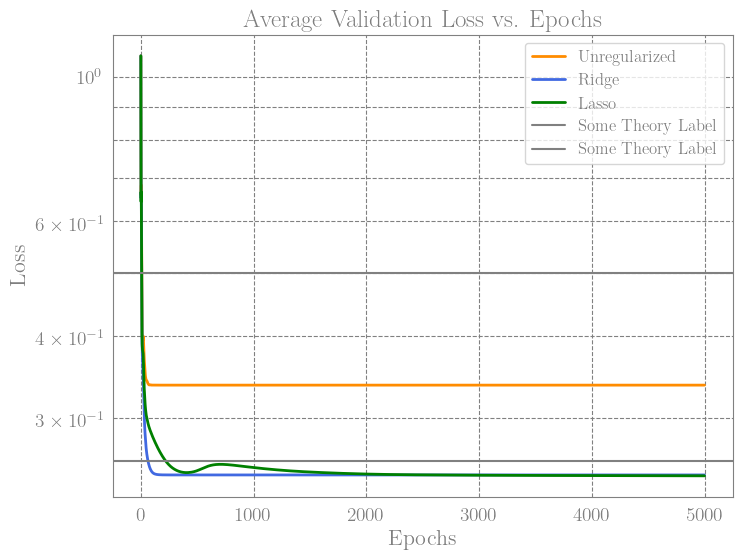

In [28]:
colors = {
    "no_WD": "darkorange",
    "WD": "royalblue",
    "SGD_L1": "green"
}

linestyles = {
    "no_WD": "-",
    "WD": "-",
    "SGD_L1": "-"
}

labels = {
    "no_WD": r"Unregularized",
    "WD": r"Ridge",
    "SGD_L1": r"Lasso"
}


order = ["no_WD", "WD", "SGD_L1"]


# Average loss history
avg_loss_histories = {method: np.mean(loss_histories[method], axis=0) for method in loss_histories}

plt.figure(figsize=(8, 6))

for method in order:
    plt.semilogy(avg_loss_histories[method], label=labels[method], color=colors[method], linestyle=linestyles[method], linewidth=2)


plt.axhline(1.03*0.5/2, color=text_and_line_color, ls='-', label=r"Some Theory Label")
plt.axhline(0.5, color=text_and_line_color, ls='-', label=r"Some Theory Label")

plt.title(r'Average Validation Loss vs. Epochs')
plt.xlabel(r'Epochs')
plt.ylabel(r'Loss')
# plt.xlim(-10, 150)
# plt.ylim(1e-1,2)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, which="both", ls="--", c=text_and_line_color)


plt.show()


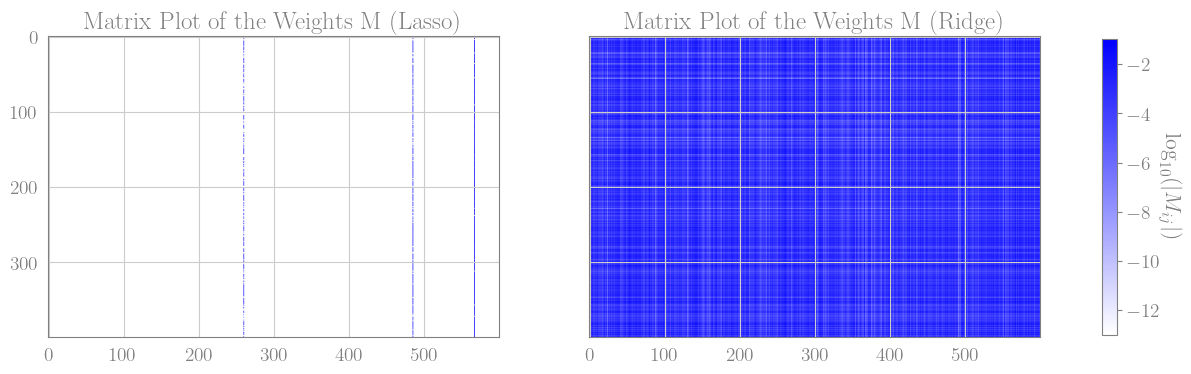

In [29]:
from matplotlib.colors import LinearSegmentedColormap



M1 = np.log10(np.abs(S_L1.M.detach().numpy()) + 1e-13)
M2 = np.log10(np.abs(S_WD.M.detach().numpy()) + 1e-13)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

colors = [(0, 0, 1, alpha) for alpha in np.linspace(0, 1, 256)]
cmap = LinearSegmentedColormap.from_list('custom_blue', colors, N=256)

im1 = ax1.imshow(M1, cmap=cmap)
im2 = ax2.imshow(M2, cmap=cmap)

colorbar = fig.colorbar(im1, ax=[ax1, ax2], shrink=0.48, aspect=20)

ax1.set_title('Matrix Plot of the Weights M (Lasso)')
ax2.set_title('Matrix Plot of the Weights M (Ridge)')
colorbar.set_label(r'$\log_{10}(|M_{ij}|)$', rotation=270, labelpad=15)

plt.savefig('/Users/nadavoutmezguine/Library/CloudStorage/Dropbox/Mac/Documents/Nadav-out.github.io/assets/images/gen_deeper_weights.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()


## Non-linear?

In [7]:
class StudentModelNL(nn.Module):
    def __init__(self, D, v):
        super(StudentModelNL, self).__init__()

        # He Initialization
        self.M = nn.Parameter(torch.randn(D, v) * np.sqrt(2. / D))
        self.V = nn.Parameter(torch.randn(v) * np.sqrt(1. / v))
        self.relu = nn.ReLU()

    def forward(self, X):
        M_output = X @ self.M
        activated_output = self.relu(M_output)
        return activated_output @ self.V


In [8]:
def train_model(hyperparameters, num_runs=100, epochs=500):
    # Extract hyperparameters
    D = hyperparameters['D']
    v = hyperparameters['v']
    v_teacher = hyperparameters['v_teacher']
    q = hyperparameters['q']
    lr_L1 = hyperparameters['lr_L1']
    l1_lambda = hyperparameters['l1_lambda']
    lr_L2 = hyperparameters['lr_L2']
    WD = hyperparameters['WD']
    momentum = hyperparameters['momentum']
    L1_WD = hyperparameters['L1_WD']

    # Setting up random seeds for reproducibility
    torch.manual_seed(23409687)

    # Initialize teacher network and keep it fixed
    teacher = StudentModelNL(D, v_teacher)
    for param in teacher.parameters():
        param.requires_grad = False

    # Lists to store all loss histories for each run
    loss_histories = {
        "no_WD": {
            "train": [],
            "val": []
        },
        "WD": {
            "train": [],
            "val": []
        },
        "SGD_L1": {
            "train": [],
            "val": []
        }
    }

    for run in tqdm.trange(num_runs):
        # Generate new training and validation data
        X = torch.randn(int(q * D), D) / np.sqrt(q * D)
        X_val = torch.randn(int(q * D), D) / np.sqrt(q * D) # Validation data

        # Reset initial student network for each run
        student_init = StudentModelNL(D, v)
        
        student_no_WD = copy.deepcopy(student_init)
        student_WD = copy.deepcopy(student_init)
        student_SGD_L1 = copy.deepcopy(student_init)

        # Initialize optimizers
        optimizer_no_WD = torch.optim.SGD(student_no_WD.parameters(), lr=lr_L2, momentum=momentum)
        optimizer_WD = torch.optim.SGD(student_WD.parameters(), lr=lr_L2, weight_decay=WD, momentum=momentum)
        optimizer_SGD_L1 = SGD_L1(student_SGD_L1.parameters(), l1_lambda=l1_lambda, lr=lr_L1, weight_decay=L1_WD, momentum=momentum)

        # Track loss history for each method
        loss_histories_for_run = {
            "no_WD": {
                "train": [],
                "val": []
            },
            "WD": {
                "train": [],
                "val": []
            },
            "SGD_L1": {
                "train": [],
                "val": []
            }
        }

        for epoch in range(epochs):
            for method, optimizer, student in zip(
                loss_histories.keys(), 
                [optimizer_no_WD, optimizer_WD, optimizer_SGD_L1], 
                [student_no_WD, student_WD, student_SGD_L1]):

                optimizer.zero_grad()

                # Training Loss
                student_output_train = student(X)
                teacher_output_train = teacher(X) 
                train_loss = torch.norm(student_output_train - teacher_output_train)**2 / 2

                # Validation Loss
                student_output_val = student(X_val)
                teacher_output_val = teacher(X_val)  
                val_loss = torch.norm(student_output_val - teacher_output_val)**2 / 2

                # Backward pass and optimization
                train_loss.backward()
                optimizer.step()

                # Append losses to history
                loss_histories_for_run[method]["train"].append(train_loss.item())
                loss_histories_for_run[method]["val"].append(val_loss.item())

        # Append loss histories for this run
        for method in loss_histories.keys():
            loss_histories[method]["train"].append(loss_histories_for_run[method]["train"])
            loss_histories[method]["val"].append(loss_histories_for_run[method]["val"])
    
    return loss_histories, student_SGD_L1, student_WD

# Usage:
hyperparameters = {
    'D': 100,
    'v': 100,
    'v_teacher': 10,
    
    'q': 0.6,
    
    'momentum': 0.5,
    
    'lr_L1': 0.01,
    'lr_L2': 0.02,
    
    'l1_lambda': 0.001,
    'WD': 0.05,
    'L1_WD': 0.05
}

loss_histories, S_L1, S_WD = train_model(hyperparameters, num_runs=10,epochs=10000)

100%|██████████| 10/10 [01:09<00:00,  6.93s/it]


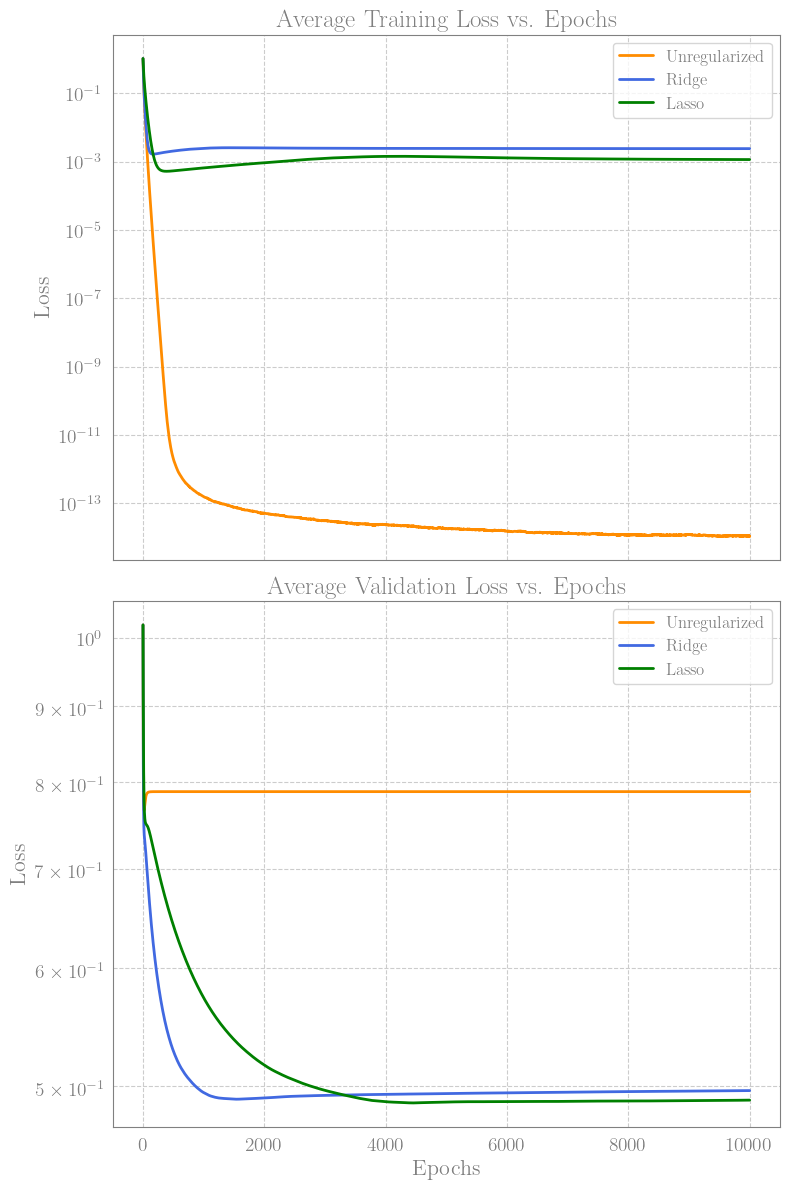

In [9]:
colors = {
    "no_WD": "darkorange",
    "WD": "royalblue",
    "SGD_L1": "green"
}

linestyles = {
    "no_WD": "-",
    "WD": "-",
    "SGD_L1": "-"
}

labels = {
    "no_WD": r"Unregularized",
    "WD": r"Ridge",
    "SGD_L1": r"Lasso"
}

order = ["no_WD", "WD", "SGD_L1"]

# Averaging the loss histories
avg_loss_histories_train = {method: np.mean(loss_histories[method]["train"], axis=0) for method in loss_histories}
avg_loss_histories_val = {method: np.mean(loss_histories[method]["val"], axis=0) for method in loss_histories}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

# Plot for Training Loss
for method in order:
    ax1.semilogy(avg_loss_histories_train[method], label=labels[method], color=colors[method], linestyle=linestyles[method], linewidth=2)
ax1.set_title(r'Average Training Loss vs. Epochs')
ax1.set_ylabel(r'Loss')
ax1.legend(fontsize=12, loc='upper right')
ax1.grid(True, which="both", ls="--")

# Plot for Validation Loss
for method in order:
    ax2.semilogy(avg_loss_histories_val[method], label=labels[method], color=colors[method], linestyle=linestyles[method], linewidth=2)
ax2.set_title(r'Average Validation Loss vs. Epochs')
ax2.set_xlabel(r'Epochs')
ax2.set_ylabel(r'Loss')
ax2.legend(fontsize=12, loc='upper right')
ax2.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


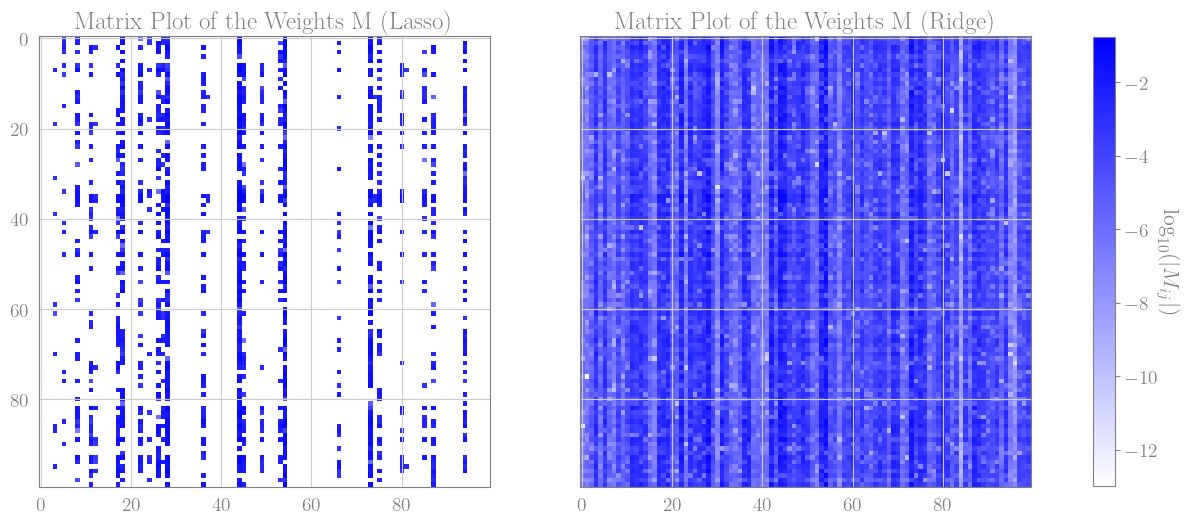

In [10]:
from matplotlib.colors import LinearSegmentedColormap



M1 = np.log10(np.abs(S_L1.M.detach().numpy()) + 1e-13)
M2 = np.log10(np.abs(S_WD.M.detach().numpy()) + 1e-13)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

colors = [(0, 0, 1, alpha) for alpha in np.linspace(0, 1, 256)]
cmap = LinearSegmentedColormap.from_list('custom_blue', colors, N=256)

im1 = ax1.imshow(M1, cmap=cmap)
im2 = ax2.imshow(M2, cmap=cmap)

colorbar = fig.colorbar(im1, ax=[ax1, ax2], shrink=0.73, aspect=20)

ax1.set_title('Matrix Plot of the Weights M (Lasso)')
ax2.set_title('Matrix Plot of the Weights M (Ridge)')
colorbar.set_label(r'$\log_{10}(|M_{ij}|)$', rotation=270, labelpad=15)

plt.savefig('/Users/nadavoutmezguine/Library/CloudStorage/Dropbox/Mac/Documents/Nadav-out.github.io/assets/images/gen_non_lin_weights.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()
